# Read shp file

<Axes: >

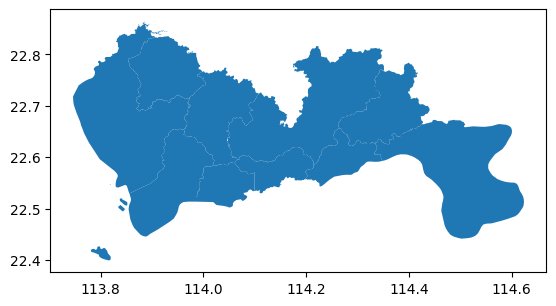

In [30]:
#Import necessary packages
import pandas as pd
import numpy as np

#Package for drawing
import matplotlib as mpl
import matplotlib.pyplot as plt

#geopandas
import geopandas

#shapely
from shapely.geometry import Point,Polygon,shape

#read shapefile
shp = r'shapefile/sz.shp'
sz = geopandas.GeoDataFrame.from_file(shp,encoding = 'utf-8')

#Let's plot to see what it looks like
sz.plot()

Note: Sometimes when you use sz.plot() it only show something like  
<matplotlib.axes._subplots.AxesSubplot at 0x187a50303c8>  
and without any figures  
Don't worry, run it again then it will show


In [31]:
type(sz)

geopandas.geodataframe.GeoDataFrame

The format of **GeoDataFrame** is a datatable similar to pandas DataFrame, but with a column of geometry store the gis information of each row

In [32]:
sz.head(5)

centroid_x  centroid_y  qh  \
0  114.143157   22.577605  罗湖   
1  114.041535   22.546180  福田   
2  114.270206   22.596432  盐田   
3  113.851387   22.679120  宝安   
4  113.926290   22.766157  光明   

                                            geometry  
0  POLYGON ((114.10006 22.53431, 114.09969 22.535...  
1  POLYGON ((113.98578 22.51348, 113.98558 22.523...  
2  POLYGON ((114.22772 22.54290, 114.22643 22.543...  
3  MULTIPOLYGON (((113.81831 22.54676, 113.81816 ...  
4  POLYGON ((113.98587 22.80304, 113.98605 22.802...

The gis information in every row of geometry column is the **POLYGON** in shapely package, let's get one out to see what it looks like

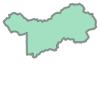

In [33]:
# geometry of the first row
sz['geometry'].iloc[0]

In [34]:
type(sz['geometry'].iloc[0])

shapely.geometry.polygon.Polygon

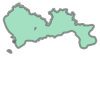

In [35]:
#With the method unary_union, all records of a geopandas can be merged into a single Polygon
sz.unary_union

# Generate spatial grids

Here, I want to use a method that can generate spatial grids shapefile, and also can easily calculate the corresponding grid number from longitude and latitude of the GPS data

Principle of Gridding
<img src="resource/grid_en.png" style="width:500px">


In [36]:
#Code for gridding
import math
#Define a test lon and lat
testlon = 114
testlat = 22.5

#Define the scope
lon1 = 113.75194
lon2 = 114.624187
lat1 = 22.447837
lat2 = 22.864748

latStart = min(lat1, lat2);
lonStart = min(lon1, lon2);

#Define the size of grid(m)
accuracy = 500;

#Calculate the length of latitude and longitude of the grids: ▲Lon and ▲Lat
deltaLon = accuracy * 360 / (2 * math.pi * 6371004 * math.cos((lat1 + lat2) * math.pi / 360));
deltaLat = accuracy * 360 / (2 * math.pi * 6371004);

#Calculate the loncol and latcol number of the grid
LONCOL=divmod(float(testlon) - (lonStart - deltaLon / 2) , deltaLon)[0]
LATCOL=divmod(float(testlat) - (latStart - deltaLat / 2) , deltaLat)[0]

#Calculate the coordinate of the grid center
HBLON = LONCOL*deltaLon + (lonStart - deltaLon / 2)
HBLAT = LATCOL*deltaLat + (latStart - deltaLat / 2)

#print the result
LONCOL,LATCOL,HBLON,HBLAT,deltaLon,deltaLat

(51.0,
 12.0,
 113.99800701150498,
 22.499547959873865,
 0.004872614089207591,
 0.004496605206422906)

generate spatial grids GeoDataFrame

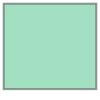

In [37]:
from shapely.geometry import Point,Polygon,shape
Polygon([(HBLON+deltaLon/2,HBLAT-deltaLat/2),
        (HBLON+deltaLon/2,HBLAT+deltaLat/2),
        (HBLON-deltaLon/2,HBLAT+deltaLat/2),
        (HBLON-deltaLon/2,HBLAT-deltaLat/2)])

/var/folders/lq/9vy4g6b12qq8qbkpm8pf5mf80000gn/T/ipykernel_1444/1181777888.py:54: FutureWarning: You are adding a column named 'geometry' to a GeoDataFrame constructed without an active geometry column. Currently, this automatically sets the active geometry column to 'geometry' but in the future that will no longer happen. Instead, either provide geometry to the GeoDataFrame constructor (GeoDataFrame(... geometry=GeoSeries()) or use `set_geometry('geometry')` to explicitly set the active geometry column.
  data['geometry'] = geometry


<Axes: >

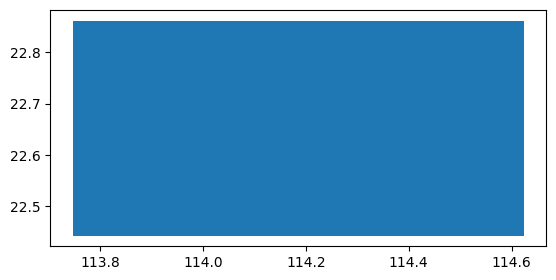

In [38]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import geopandas
from shapely.geometry import Point,Polygon,shape


#define an empty GeoDataFrame
data = geopandas.GeoDataFrame()

#define empty lists，It's going to add something into it in every iteration
LONCOL = []
LATCOL = []
geometry = []
HBLON1 = []
HBLAT1 = []

#Calculate how many grids to generate in total
#lonsnum grids for lon direstion
lonsnum = int((lon2-lon1)/deltaLon)+1
#latsnum grids for lat direstion
latsnum = int((lat2-lat1)/deltaLat)+1

for i in range(lonsnum):
    for j in range(latsnum):

        HBLON = i*deltaLon + (lonStart - deltaLon / 2)
        HBLAT = j*deltaLat + (latStart - deltaLat / 2)
        #add things into lists
        LONCOL.append(i)
        LATCOL.append(j)
        HBLON1.append(HBLON)
        HBLAT1.append(HBLAT)
        
        #Generate grid Polygon
        #Here we use the surrounding grids to calculate the position of the three vertices of the grid
        #otherwise the generated grid will have small cracks due to the problem of decimal value and cannot be covered perfectly
        HBLON_1 = (i+1)*deltaLon + (lonStart - deltaLon / 2)
        HBLAT_1 = (j+1)*deltaLat + (latStart - deltaLat / 2)
        
        #Add grid Polygon into list
        geometry.append(Polygon([
        (HBLON-deltaLon/2,HBLAT-deltaLat/2),
        (HBLON_1-deltaLon/2,HBLAT-deltaLat/2),
        (HBLON_1-deltaLon/2,HBLAT_1-deltaLat/2),
        (HBLON-deltaLon/2,HBLAT_1-deltaLat/2)]))
        
#Assign lists as the columns of the GeoDataFrame
data['LONCOL'] = LONCOL
data['LATCOL'] = LATCOL
data['HBLON'] = HBLON1
data['HBLAT'] = HBLAT1
data['geometry'] = geometry

data.plot()


Note: if seaborn (another drawing package) is opened, even if the data is the same, the drawing may be different. I suggest not to use seaborn here.

In [39]:
data.head(5)

LONCOL  LATCOL       HBLON      HBLAT  \
0       0       0  113.749504  22.445589   
1       0       1  113.749504  22.450085   
2       0       2  113.749504  22.454582   
3       0       3  113.749504  22.459079   
4       0       4  113.749504  22.463575   

                                            geometry  
0  POLYGON ((113.74707 22.44334, 113.75194 22.443...  
1  POLYGON ((113.74707 22.44784, 113.75194 22.447...  
2  POLYGON ((113.74707 22.45233, 113.75194 22.452...  
3  POLYGON ((113.74707 22.45683, 113.75194 22.456...  
4  POLYGON ((113.74707 22.46133, 113.75194 22.461...

obtain the intersection of the grids generated and Shenzhen administrative division:

<Axes: >

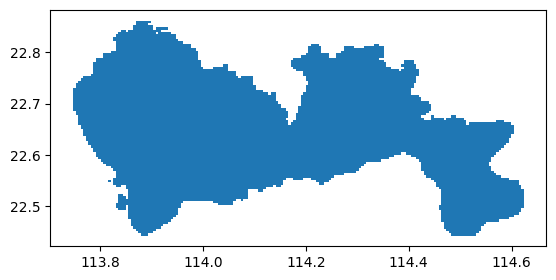

In [40]:
grid = data[data.intersects(sz.unary_union)]
grid.plot()

In [41]:
#save grids
grid.to_file(r'shapefile\grid',encoding = 'utf-8')

# Map GPS data to grid

Tip: we have gridded testlon and testlat in the previous step, so how to grid all OD data of taxis? (please do not use loop, the efficiency is very low)

>In the last tutorial, we have extracted od from the original GPS data of taxis and saved it in  
data-sample/TaxiOD.csv
    

In [42]:
import pandas as pd
TaxiOD = pd.read_csv(r'data_sample/taxi_OD.csv')
TaxiOD.columns = ['VehicleNum', 'Stime', 'SLng', 'SLat', 
       'ELng', 'ELat','Etime']
TaxiOD.head(5)

VehicleNum     Stime        SLng       SLat        ELng       ELat  \
0       22334  00:07:44  114.080498  22.554182  114.084915  22.540850   
1       22334  00:18:56  114.084915  22.540850  114.056236  22.633383   
2       22334  02:38:35  114.091637  22.543200  114.093498  22.554382   
3       22334  03:58:46  114.038818  22.553232  114.052299  22.604366   
4       22334  06:30:11  114.031250  22.519550  114.067886  22.521299   

      Etime  
0  00:17:58  
1  00:44:47  
2  02:46:52  
3  04:13:57  
4  06:41:19

In [43]:
TaxiOD = TaxiOD[-TaxiOD['ELng'].isnull()].copy()
TaxiOD['SLONCOL'] = ((TaxiOD['SLng'] - (lonStart - deltaLon / 2))/deltaLon).astype('int')
TaxiOD['SLATCOL'] = ((TaxiOD['SLat'] - (latStart - deltaLat / 2))/deltaLat).astype('int')
TaxiOD['SHBLON'] = TaxiOD['SLONCOL']*deltaLon + (lonStart - deltaLon / 2)
TaxiOD['SHBLAT'] = TaxiOD['SLATCOL']*deltaLat + (latStart - deltaLat / 2)
TaxiOD['ELONCOL'] = ((TaxiOD['ELng'] - (lonStart - deltaLon / 2))/deltaLon).astype('int')
TaxiOD['ELATCOL'] = ((TaxiOD['ELat'] - (latStart - deltaLat / 2))/deltaLat).astype('int')
TaxiOD['EHBLON'] = TaxiOD['ELONCOL']*deltaLon + (lonStart - deltaLon / 2)
TaxiOD['EHBLAT'] = TaxiOD['ELATCOL']*deltaLat + (latStart - deltaLat / 2)
#Filter out od with start and end points in the same grid
TaxiOD = TaxiOD[-((TaxiOD['SLONCOL']==TaxiOD['ELONCOL'])&(TaxiOD['SLATCOL']==TaxiOD['ELATCOL']))]
#Filter out the grids that are not in the research scope
TaxiOD = TaxiOD[(TaxiOD['SLONCOL']>=0) & (TaxiOD['SLATCOL']>=0) &(TaxiOD['ELONCOL']>=0) & (TaxiOD['ELATCOL']>=0)&
(TaxiOD['SLONCOL']<=lonsnum) & (TaxiOD['SLATCOL']<=latsnum) &(TaxiOD['ELONCOL']<=lonsnum) & (TaxiOD['ELATCOL']<=latsnum)]

TaxiOD.head(5)

VehicleNum     Stime        SLng       SLat        ELng       ELat  \
0       22334  00:07:44  114.080498  22.554182  114.084915  22.540850   
1       22334  00:18:56  114.084915  22.540850  114.056236  22.633383   
2       22334  02:38:35  114.091637  22.543200  114.093498  22.554382   
3       22334  03:58:46  114.038818  22.553232  114.052299  22.604366   
4       22334  06:30:11  114.031250  22.519550  114.067886  22.521299   

      Etime  SLONCOL  SLATCOL      SHBLON     SHBLAT  ELONCOL  ELATCOL  \
0  00:17:58       67       24  114.075969  22.553507       68       21   
1  00:44:47       68       21  114.080841  22.540017       62       41   
2  02:46:52       70       21  114.090587  22.540017       70       24   
3  04:13:57       59       23  114.036988  22.549011       62       35   
4  06:41:19       57       16  114.027243  22.517534       65       16   

       EHBLON     EHBLAT  
0  114.080841  22.540017  
1  114.051606  22.629950  
2  114.090587  22.553507  
3  114.051606  22.602970  
4  114.066224  22.517534

# Aggregate grid OD (All day, Peak hours)

In [44]:
OD= TaxiOD.groupby(['SLONCOL','SLATCOL','ELONCOL','ELATCOL'])['VehicleNum'].count().reset_index()

#sort OD accroding to VehicleNum
OD = OD.sort_values(by = 'VehicleNum',ascending = False)

# Plot the OD

## plot the top 20 OD

In [45]:
#Take the top 20 OD
Topod = OD.iloc[:20].copy()

#Calculate the longitude and latitude of the starting grid center
Topod['SHBLON'] = Topod['SLONCOL'] * deltaLon + (lonStart - deltaLon / 2)
Topod['SHBLAT'] = Topod['SLATCOL'] * deltaLat + (latStart - deltaLat / 2)

#Calculate the longitude and latitude of the ending grid center
Topod['EHBLON'] = Topod['ELONCOL'] * deltaLon + (lonStart - deltaLon / 2)
Topod['EHBLAT'] = Topod['ELATCOL'] * deltaLat + (latStart - deltaLat / 2)

In [46]:
#Import drawing package
import matplotlib as mpl
import matplotlib.pyplot as plt

/var/folders/lq/9vy4g6b12qq8qbkpm8pf5mf80000gn/T/ipykernel_1444/2454190634.py:13: FutureWarning: You are adding a column named 'geometry' to a GeoDataFrame constructed without an active geometry column. Currently, this automatically sets the active geometry column to 'geometry' but in the future that will no longer happen. Instead, either provide geometry to the GeoDataFrame constructor (GeoDataFrame(... geometry=GeoSeries()) or use `set_geometry('geometry')` to explicitly set the active geometry column.
  SZ_all['geometry'] = [sz.unary_union]


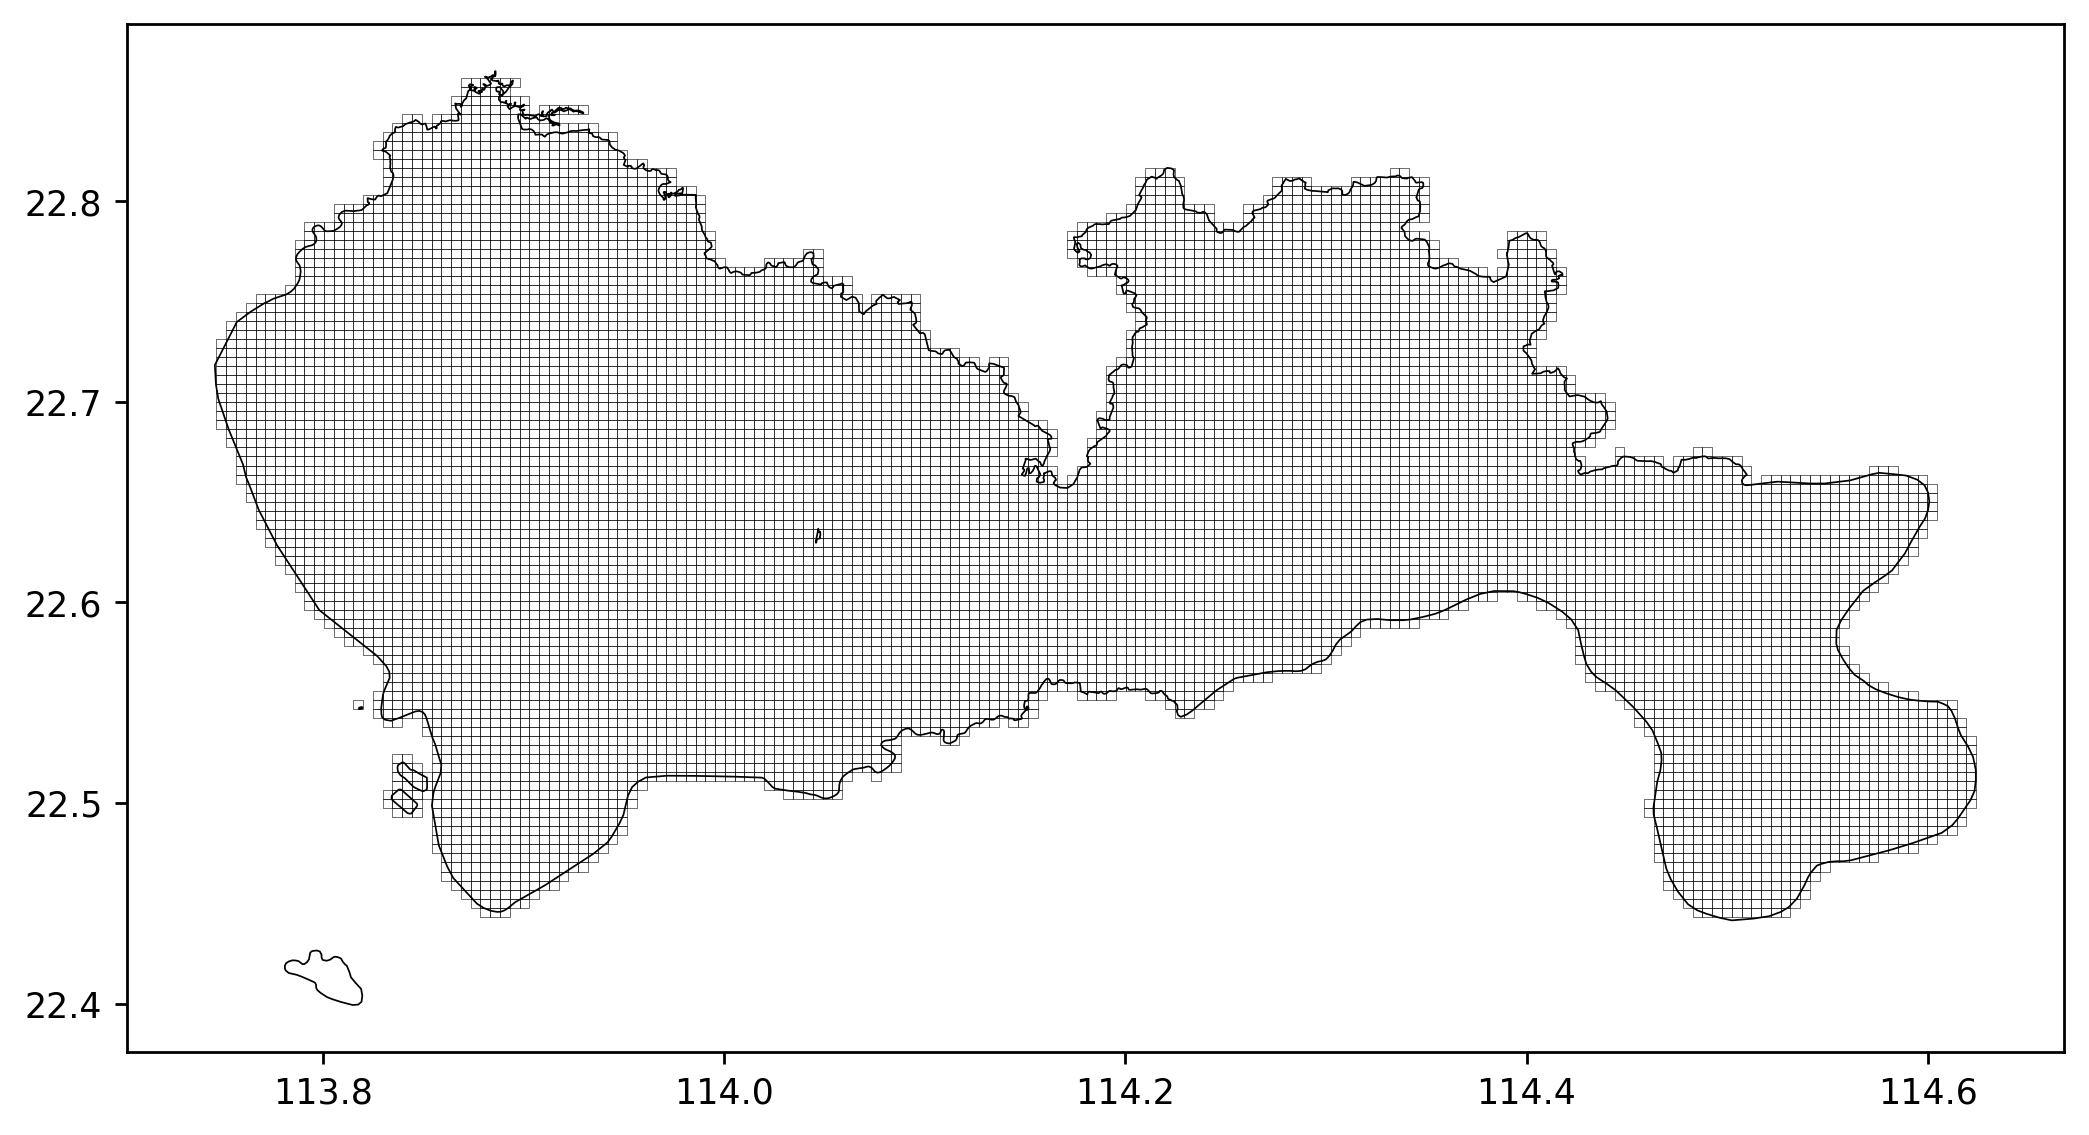

In [47]:
#generate figure
fig     = plt.figure(1,(10,8),dpi = 250)    
#add a subplot
ax      = plt.subplot(111)
#tell python we are going to plot in this subplot
plt.sca(ax)

#plot the grids on the ax
grid.plot(ax =ax,edgecolor = (0,0,0,0.8),facecolor = (0,0,0,0),linewidths=0.2)

#Transform the merged administrative division into a geodataframe, and draw it on ax
SZ_all = geopandas.GeoDataFrame()
SZ_all['geometry'] = [sz.unary_union]
SZ_all.plot(ax = ax,edgecolor = (0,0,0,1),facecolor = (0,0,0,0),linewidths=0.5)

plt.show()

In [48]:
#Let's plot OD
fig     = plt.figure(1,(10,8),dpi = 250)    
ax      = plt.subplot(111)
plt.sca(ax)
grid.plot(ax =ax,edgecolor = (0,0,0,0.8),facecolor = (0,0,0,0),linewidths=0.2)
SZ_all.plot(ax = ax,edgecolor = (0,0,0,1),facecolor = (0,0,0,0),linewidths=0.5)



for i in range(len(Topod)):
###########################You need to write code here#############################
    #First obtain the longitude and latitude of OD
    #And use plt.plot to plot OD
    

##################################################################################
#不显示坐标轴
plt.axis('off')

plt.show()

IndentationError: expected an indented block (762190522.py, line 18)

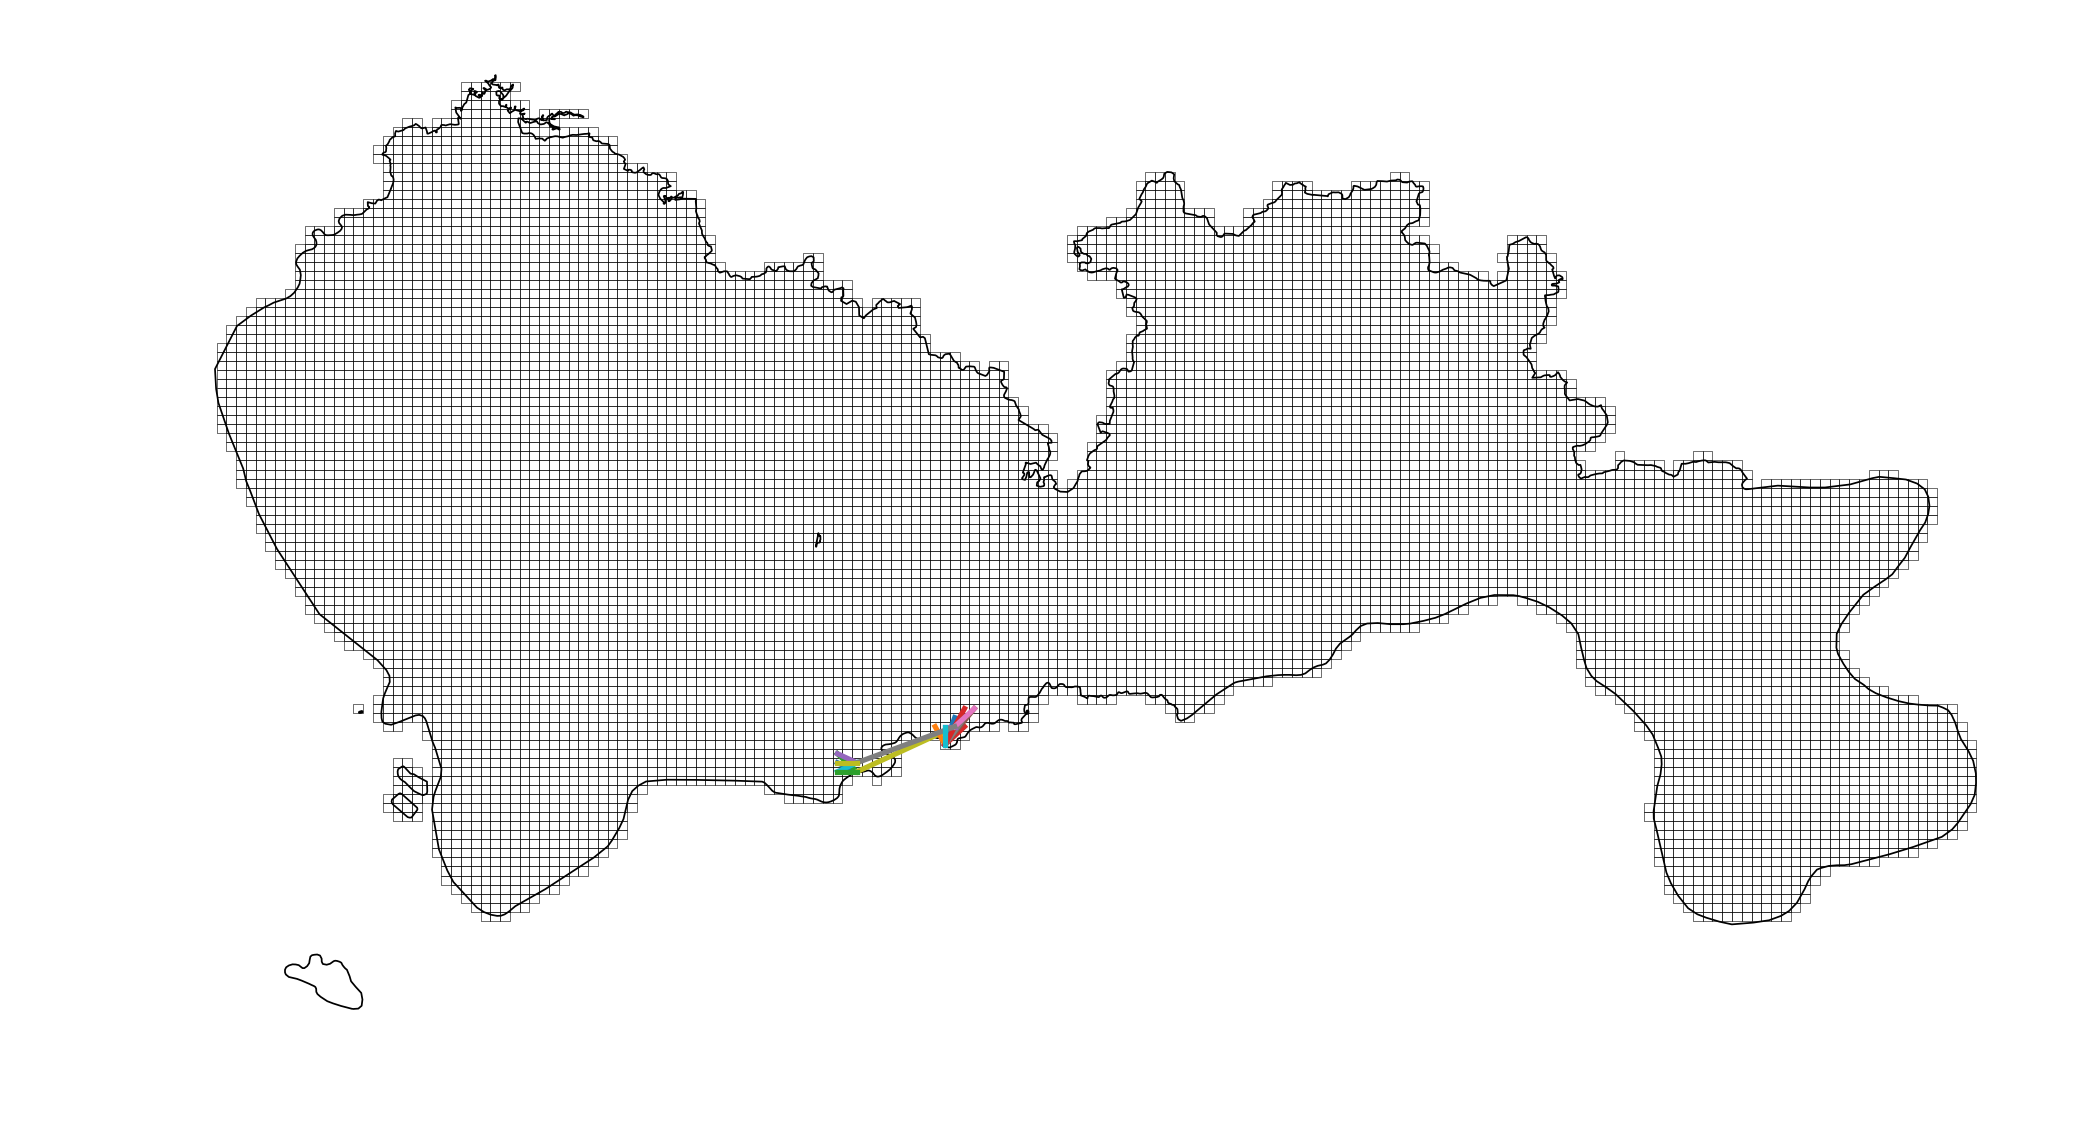

In [ ]:
###############################     Answer   ##################################
fig     = plt.figure(1,(10,8),dpi = 250)    
ax      = plt.subplot(111)
plt.sca(ax)

grid.plot(ax =ax,edgecolor = (0,0,0,0.8),facecolor = (0,0,0,0),linewidths=0.2)
SZ_all.plot(ax = ax,edgecolor = (0,0,0,1),facecolor = (0,0,0,0),linewidths=0.5)

for i in range(len(Topod)):

    
    plt.plot([Topod['SHBLON'].iloc[i],Topod['EHBLON'].iloc[i]],[Topod['SHBLAT'].iloc[i],Topod['EHBLAT'].iloc[i]])


#don't show axis
plt.axis('off')

plt.show()
##################################################################################

## Plot all the OD

Let's plot more OD. At this time, we use the linewidth, color and transparency of OD to display the volume of OD

In [ ]:
OD1 = OD[OD['VehicleNum']>10].copy()

#Here we sort the OD from small to large
#because we want to plot small OD first so that it will be in the bottom
OD1 = OD1.sort_values(by = 'VehicleNum')

OD1['SHBLON'] = OD1['SLONCOL'] * deltaLon + (lonStart - deltaLon / 2)
OD1['SHBLAT'] = OD1['SLATCOL'] * deltaLat + (latStart - deltaLat / 2)
OD1['EHBLON'] = OD1['ELONCOL'] * deltaLon + (lonStart - deltaLon / 2)
OD1['EHBLAT'] = OD1['ELATCOL'] * deltaLat + (latStart - deltaLat / 2)

#Divided OD into five groups, and generate a column with a value of 0-1 
#The values of each group are the same, which is used to represent the linewidth of OD
#named linewidth

step = 5
OD1['linewidth'] = (np.array(range(len(OD1)))*step/len(OD1)).astype('int')/step+0.1
OD1.head(5)

SLONCOL  SLATCOL  ELONCOL  ELATCOL  VehicleNum      SHBLON     SHBLAT  \
41465        37       17       34       21          11  113.929790  22.522031   
93970        59       27       61       20          11  114.036988  22.566997   
149728       74       20       76       27          11  114.110077  22.535521   
38433        36       18       37       18          11  113.924918  22.526528   
138355       71       23       68       23          11  114.095459  22.549011   

            EHBLON     EHBLAT  linewidth  
41465   113.915173  22.540017        0.1  
93970   114.046733  22.535521        0.1  
149728  114.119822  22.566997        0.1  
38433   113.929790  22.526528        0.1  
138355  114.080841  22.549011        0.1

绘制OD用时 31.63205885887146 秒


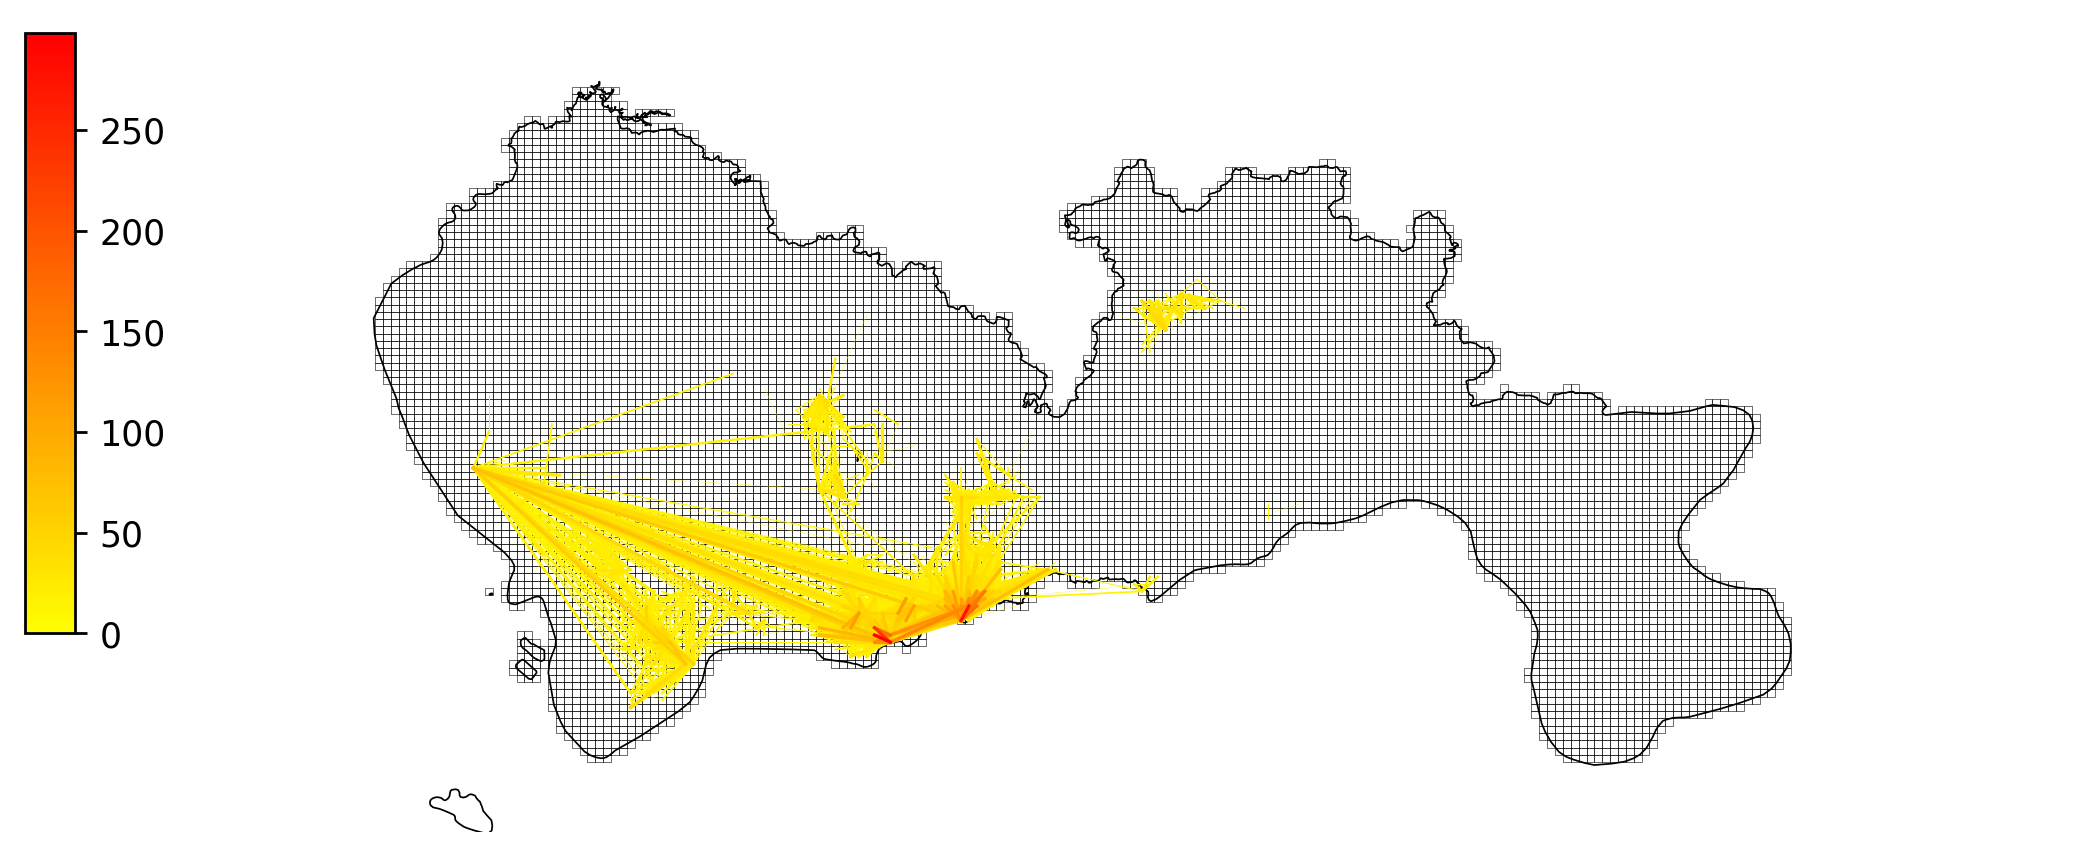

In [ ]:
fig     = plt.figure(1,(10,8),dpi = 250)    
ax      = plt.subplot(111)
plt.sca(ax)
grid.plot(ax = ax,edgecolor = (0,0,0,0.8),facecolor = (0,0,0,0),linewidths=0.2)
SZ_all.plot(ax = ax,edgecolor = (0,0,0,1),facecolor = (0,0,0,0),linewidths=0.5)

#set the colormap
import matplotlib
vmax = OD['VehicleNum'].max()
#Generate a normalized tool by setting the maximum and minimum value of OD. 
#Its function is to  normalize count into the range of 0-1
#by this code: norm(count)

norm = mpl.colors.Normalize(vmin=0,vmax=vmax)
#set the color of colormap
cmapname = 'autumn_r'
#cmap is a tool to get color using cmap(a), which a is a value in 0-1
cmap = matplotlib.cm.get_cmap(cmapname)

#plot OD
import time
timeflag = time.time()
for i in range(len(OD1)):
    ###########################You need to write code here#############################
    #set the alpha and color and linewidth in plt.plot 
    
    
    ###################################################################################

print('time use:',time.time()-timeflag,'s')
    

plt.axis('off')    

#here we want a colorbar for the OD plot, but want we have plotted are lines
#lines don't have colorbar, so we have to think in another way
#plt.imshow is a thing that with a colorbar
#so here, I plot a imshow in a place that we can't see and then add the colorbar

plt.imshow([[0,vmax]], cmap=cmap)
#set the size and the location of colorbar
cax = plt.axes([0.08, 0.4, 0.02, 0.3])
plt.colorbar(cax=cax)

#and we have to set the figure back to shenzhen, otherwise it will show the imshow

ax.set_xlim(113.6,114.8)
ax.set_ylim(22.4,22.9)



plt.show()

## A faster way to plot OD

If we use the way above to plot OD, the rendering speed is a little bit slow, it takes 31s to draw 5319 OD.
However, if the DataFrame is changed into a GeoDataFrame and then drawn with its own plot function, it will be much faster

In [ ]:
#generate geometry
###########################You need to write code here#############################
#changed into a GeoDataFrame
#generate geometry for each row


###################################################################################

OD1.head(5)

SLONCOL  SLATCOL  ELONCOL  ELATCOL  VehicleNum      SHBLON     SHBLAT  \
41465        37       17       34       21          11  113.929790  22.522031   
93970        59       27       61       20          11  114.036988  22.566997   
149728       74       20       76       27          11  114.110077  22.535521   
38433        36       18       37       18          11  113.924918  22.526528   
138355       71       23       68       23          11  114.095459  22.549011   

            EHBLON     EHBLAT  linewidth  \
41465   113.915173  22.540017        0.1   
93970   114.046733  22.535521        0.1   
149728  114.119822  22.566997        0.1   
38433   113.929790  22.526528        0.1   
138355  114.080841  22.549011        0.1   

                                                 geometry  
41465   LINESTRING (113.9297904142561 22.5220309859059...  
93970   LINESTRING (114.0369879242186 22.5669970379702...  
149728  LINESTRING (114.1100771355568 22.5355208015252...  
38433   LINESTRING (113.9249178001669 22.5265275911124...  
138355  LINESTRING (114.0954592932891 22.5490106171445...

In [ ]:
#generate geometry
###############################     Answer   ##################################

from shapely.geometry import LineString
OD1['geometry'] = OD1.apply(lambda r:LineString([[r['SHBLON'],r['SHBLAT']],[r['EHBLON'],r['EHBLAT']]]),axis = 1)
OD1 = geopandas.GeoDataFrame(OD1)
###################################################################################

OD1.head(5)

1.7782769203186035 s to plot the grids and shenzhen shape
 0.23633337020874023 s to plot OD


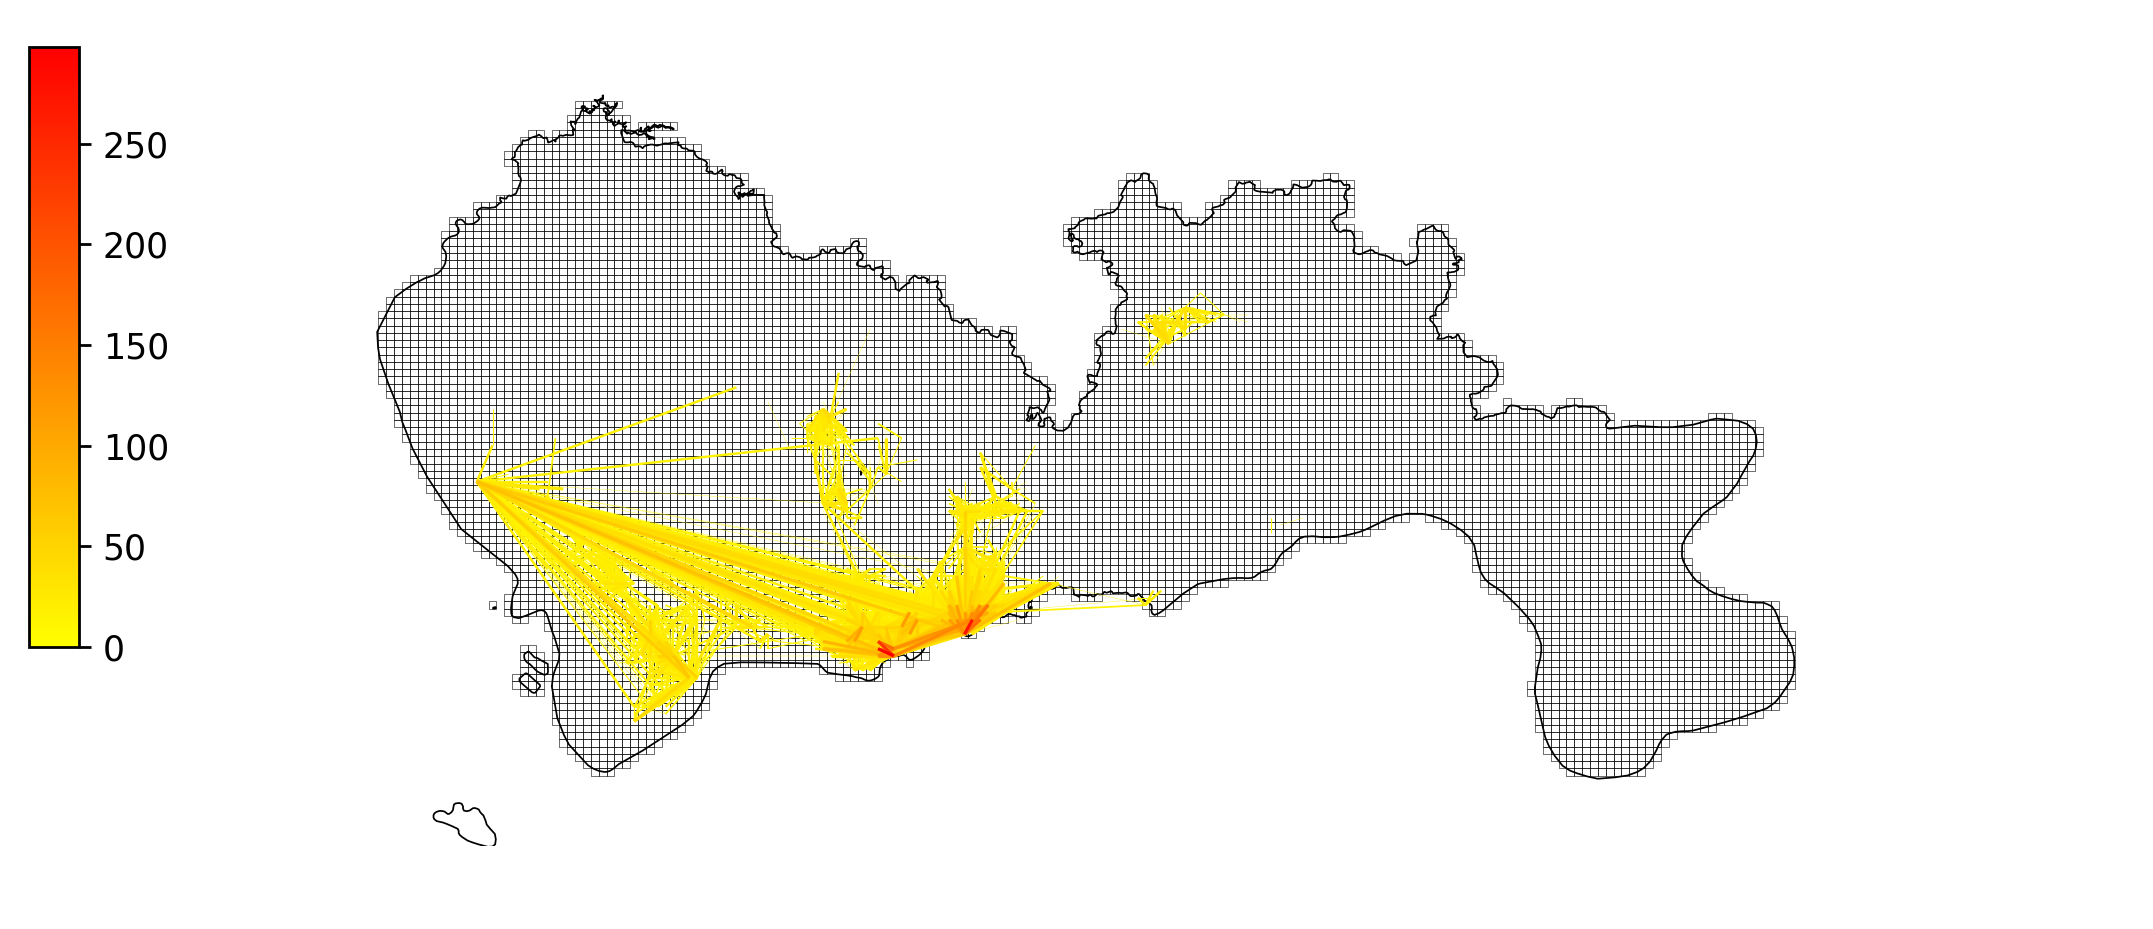

In [ ]:
fig     = plt.figure(1,(10,8),dpi = 250)    
ax      = plt.subplot(111)
plt.sca(ax)

#time it
import time
timeflag = time.time()

grid.plot(ax = ax,edgecolor = (0,0,0,0.8),facecolor = (0,0,0,0),linewidths=0.2)
SZ_all.plot(ax = ax,edgecolor = (0,0,0,1),facecolor = (0,0,0,0),linewidths=0.5)
print(time.time()-timeflag,'s to plot the grids and shenzhen shape')


#set colormap
import matplotlib
vmax = OD['VehicleNum'].max()
cmapname = 'autumn_r'
cmap = matplotlib.cm.get_cmap(cmapname)

timeflag = time.time()
#plot OD
OD1.plot(ax = ax,column = 'VehicleNum',vmax = vmax,vmin = 0,cmap = cmap,linewidth = OD1['linewidth'])
print('',time.time()-timeflag,'s to plot OD')

plt.axis('off')    
plt.imshow([[0,vmax]], cmap=cmap)
cax = plt.axes([0.08, 0.4, 0.02, 0.3])
plt.colorbar(cax=cax)
ax.set_xlim(113.6,114.8)
ax.set_ylim(22.4,22.9)
plt.show()

# Plot the grid plot

In [ ]:
#Aggregate
Odistribution = OD.groupby(['SLONCOL','SLATCOL'])['VehicleNum'].sum().reset_index()

In [ ]:
#Merge the aggregated result with the GeoDataFrame
gridtoplot = pd.merge(grid,Odistribution.rename(columns = {'SLONCOL':'LONCOL','SLATCOL':'LATCOL'}),on = ['LONCOL','LATCOL'])
gridtoplot = gridtoplot.rename(columns = {'VehicleNum':'count'})

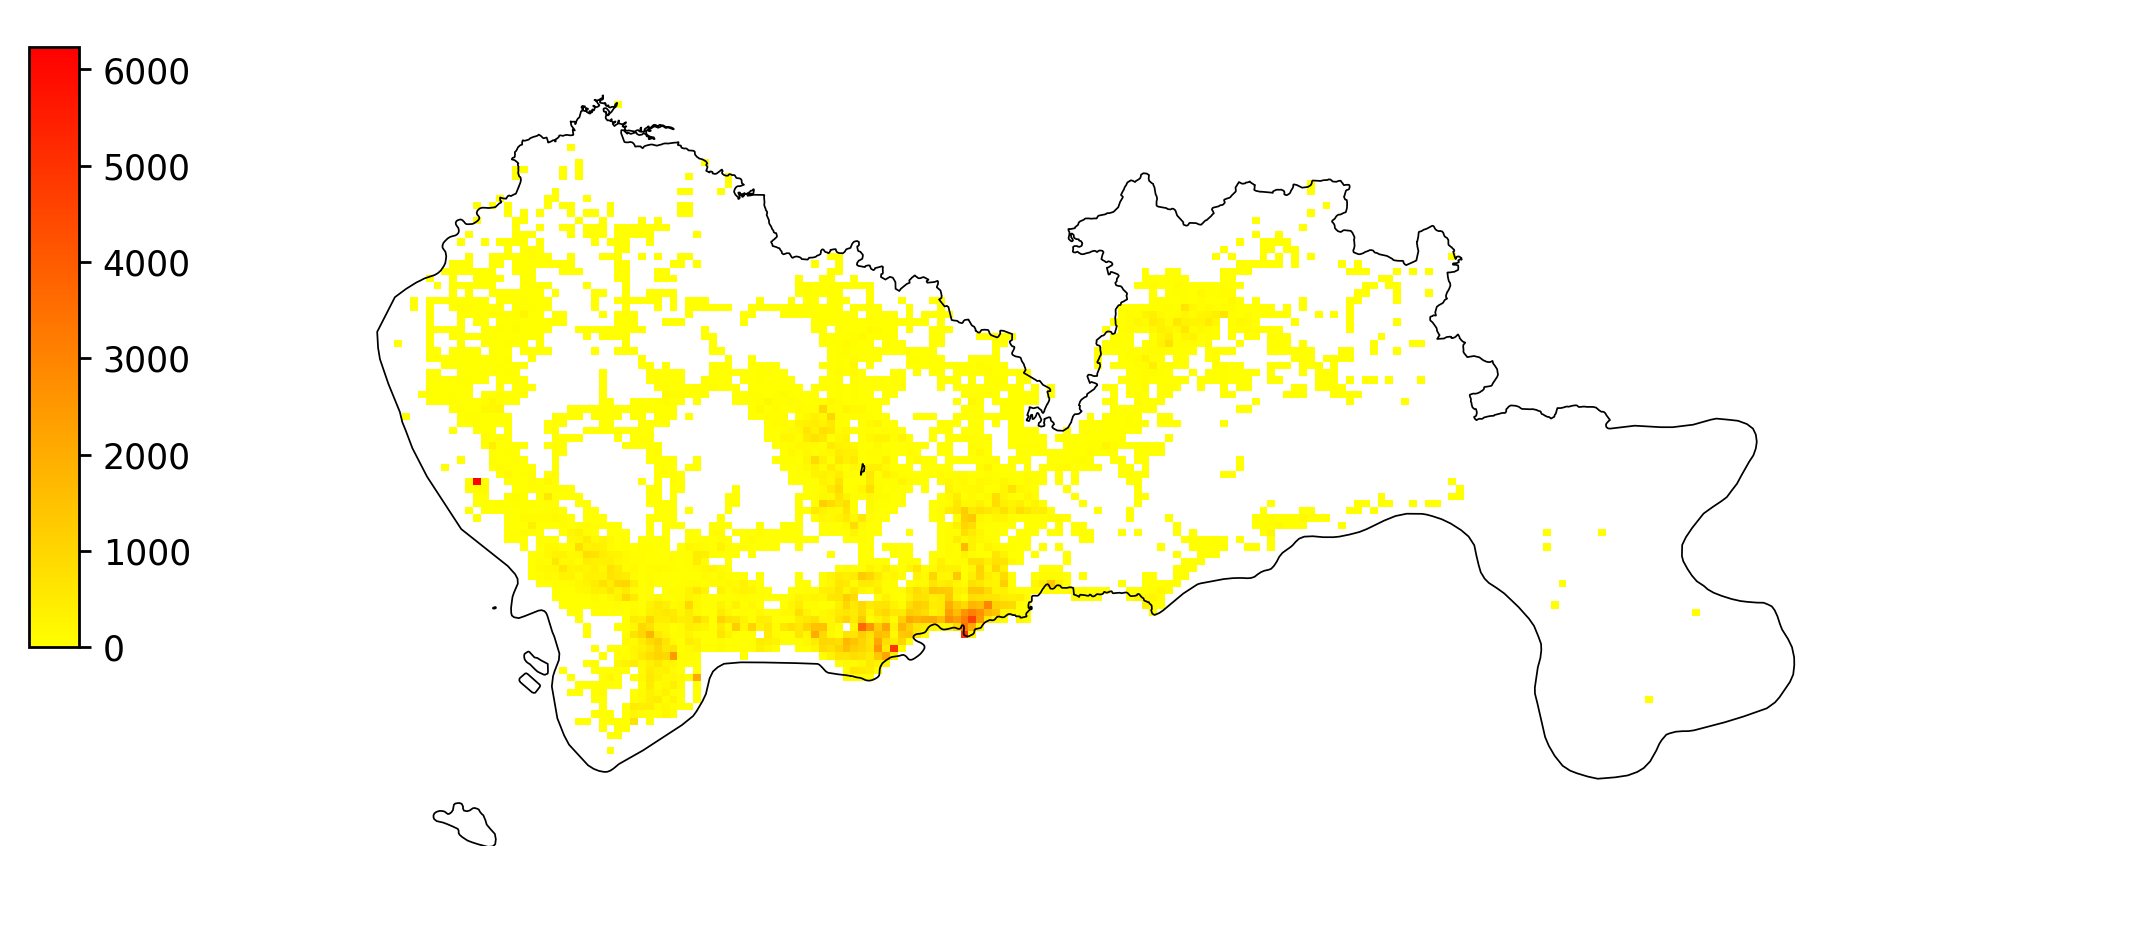

In [ ]:
fig     = plt.figure(1,(10,8),dpi = 250)    
ax      = plt.subplot(111)
plt.sca(ax)


import matplotlib
vmax = gridtoplot['count'].max()
norm = mpl.colors.Normalize(vmin=0,vmax=vmax)
cmapname = 'autumn_r'
cmap = matplotlib.cm.get_cmap(cmapname)


#Plot the gridtoplot
#Tip：Use gridtoplot.plot
#Set the parameter column = 'count'，which means that you are going to plot 
#according to the column 'count', and set cmap = cmap, which is its colormap
###########################You need to write code here#############################
#gridtoplot.plot(...)


###################################################################################

#plot the shape of Shenzhen
SZ_all.plot(ax = ax,edgecolor = (0,0,0,1),facecolor = (0,0,0,0),linewidths=0.5)



plt.axis('off')    

#plot the fake colorbar
plt.imshow([[0,vmax]], cmap=cmap)
cax = plt.axes([0.08, 0.4, 0.02, 0.3])
plt.colorbar(cax=cax)

ax.set_xlim(113.6,114.8)
ax.set_ylim(22.4,22.9)

plt.show()